
### Setup & Data Loading

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- Hyperparameters ---
BATCH_SIZE = 128
EPOCHS_CLF = 10
EPOCHS_AE = 20
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Data ---
transform = transforms.Compose([
    transforms.ToTensor(),  # scales to [0, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print(f"Training on: {DEVICE}")
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 468kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.2MB/s]

Training on: cuda
Train samples: 60000, Test samples: 10000


### Simple Feedforward Classifier

In [2]:
class FeedForwardClassifier(nn.Module):
    """
    Simple 3-layer feedforward network for digit classification.
    Architecture: 784 → 256 → 128 → 10
    """
    def __init__(self, input_dim=784, num_classes=10):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, num_classes)  # raw logits (no softmax — handled by CrossEntropyLoss)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten: (B, 1, 28, 28) → (B, 784)
        return self.network(x)

In [3]:
def train_classifier(model, train_loader, test_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses, test_accuracies = [], []

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # --- Evaluation ---
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch [{epoch}/{epochs}]  Loss: {avg_loss:.4f}  Test Acc: {accuracy:.2f}%")

    return train_losses, test_accuracies

# --- Run ---
classifier = FeedForwardClassifier().to(DEVICE)
clf_losses, clf_accuracies = train_classifier(classifier, train_loader, test_loader, EPOCHS_CLF)

Epoch [1/10]  Loss: 0.3887  Test Acc: 95.10%
Epoch [2/10]  Loss: 0.1567  Test Acc: 96.59%
Epoch [3/10]  Loss: 0.1069  Test Acc: 97.15%
Epoch [4/10]  Loss: 0.0858  Test Acc: 97.73%
Epoch [5/10]  Loss: 0.0688  Test Acc: 97.77%
Epoch [6/10]  Loss: 0.0603  Test Acc: 97.88%
Epoch [7/10]  Loss: 0.0533  Test Acc: 97.96%
Epoch [8/10]  Loss: 0.0469  Test Acc: 98.05%
Epoch [9/10]  Loss: 0.0423  Test Acc: 98.08%
Epoch [10/10]  Loss: 0.0375  Test Acc: 98.20%


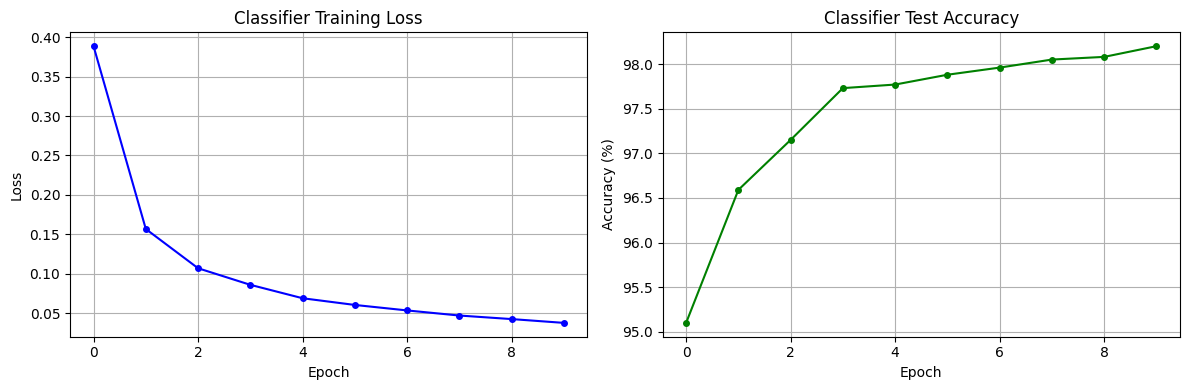

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(clf_losses, 'b-o', markersize=4)
ax1.set(title='Classifier Training Loss', xlabel='Epoch', ylabel='Loss')
ax1.grid(True)

ax2.plot(clf_accuracies, 'g-o', markersize=4)
ax2.set(title='Classifier Test Accuracy', xlabel='Epoch', ylabel='Accuracy (%)')
ax2.grid(True)
plt.tight_layout()
plt.show()

In [5]:
class Autoencoder(nn.Module):
    """
    Symmetric autoencoder.
    Encoder: 784 → 256 → 64 → latent_dim
    Decoder: latent_dim → 64 → 256 → 784
    """
    def __init__(self, input_dim=784, latent_dim=16):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()  # output in [0, 1] to match normalized pixel values
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)     # flatten
        latent = self.encoder(x)       # encode
        reconstructed = self.decoder(latent)  # decode
        return reconstructed, latent

### Training

In [6]:
def train_autoencoder(model, train_loader, epochs):
    criterion = nn.MSELoss()  # or nn.BCELoss() since output is sigmoid
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for images, _ in train_loader:  # labels not needed!
            images = images.to(DEVICE)
            flat = images.view(images.size(0), -1)

            optimizer.zero_grad()
            reconstructed, _ = model(images)
            loss = criterion(reconstructed, flat)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch}/{epochs}]  Reconstruction Loss: {avg_loss:.6f}")

    return losses

# --- Run ---
autoencoder = Autoencoder(latent_dim=16).to(DEVICE)
ae_losses = train_autoencoder(autoencoder, train_loader, EPOCHS_AE)

Epoch [1/20]  Reconstruction Loss: 0.054641
Epoch [2/20]  Reconstruction Loss: 0.029256
Epoch [3/20]  Reconstruction Loss: 0.024652
Epoch [4/20]  Reconstruction Loss: 0.021347
Epoch [5/20]  Reconstruction Loss: 0.019122
Epoch [6/20]  Reconstruction Loss: 0.017794
Epoch [7/20]  Reconstruction Loss: 0.016870
Epoch [8/20]  Reconstruction Loss: 0.016201
Epoch [9/20]  Reconstruction Loss: 0.015693
Epoch [10/20]  Reconstruction Loss: 0.015241
Epoch [11/20]  Reconstruction Loss: 0.014896
Epoch [12/20]  Reconstruction Loss: 0.014591
Epoch [13/20]  Reconstruction Loss: 0.014314
Epoch [14/20]  Reconstruction Loss: 0.014108
Epoch [15/20]  Reconstruction Loss: 0.013887
Epoch [16/20]  Reconstruction Loss: 0.013713
Epoch [17/20]  Reconstruction Loss: 0.013540
Epoch [18/20]  Reconstruction Loss: 0.013365
Epoch [19/20]  Reconstruction Loss: 0.013231
Epoch [20/20]  Reconstruction Loss: 0.013111


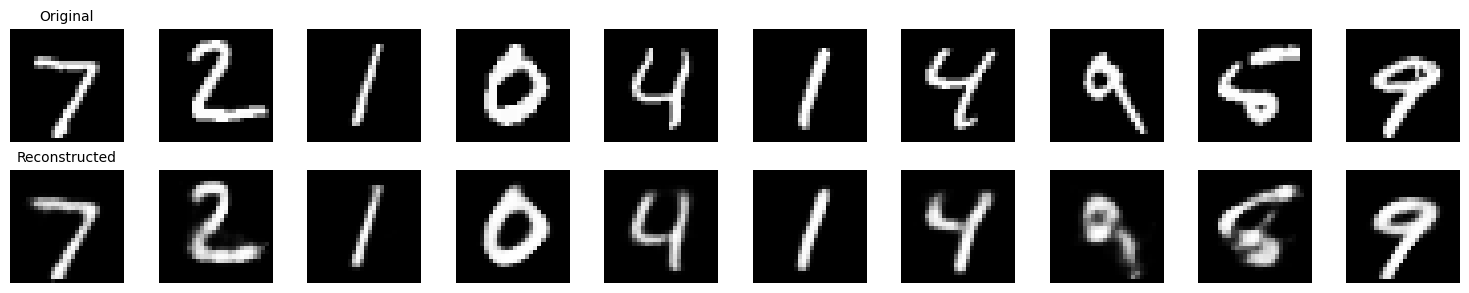

In [7]:
def visualize_reconstructions(model, test_loader, n=10):
    model.eval()
    images, _ = next(iter(test_loader))
    images = images[:n].to(DEVICE)

    with torch.no_grad():
        reconstructed, _ = model(images)

    reconstructed = reconstructed.view(-1, 1, 28, 28).cpu()
    images = images.cpu()

    fig, axes = plt.subplots(2, n, figsize=(n * 1.5, 3))
    for i in range(n):
        # Original
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)

        # Reconstructed
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_reconstructions(autoencoder, test_loader)

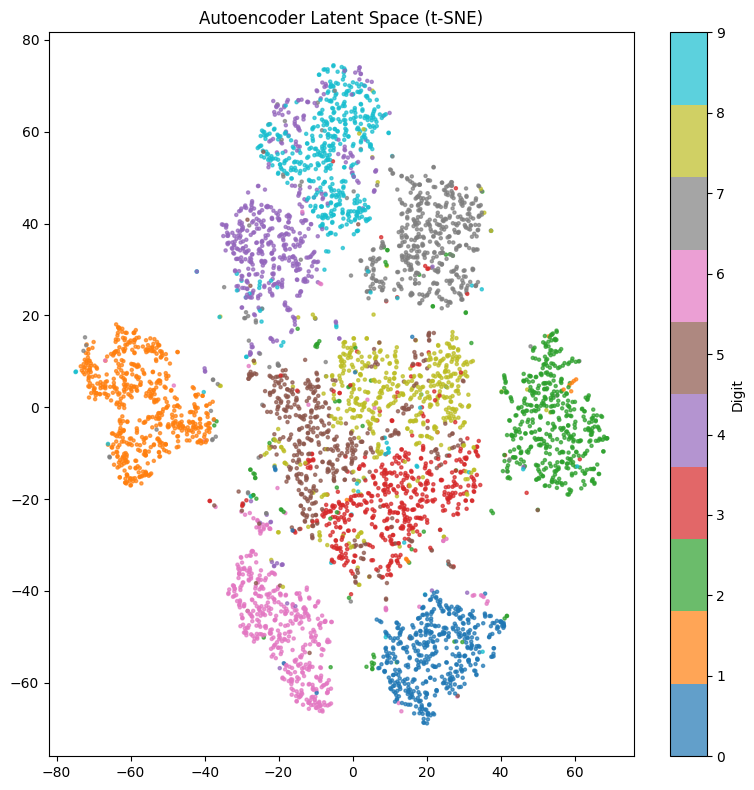

In [8]:
def visualize_latent_space(model, test_loader, max_samples=5000):
    """Project latent representations to 2D using t-SNE."""
    from sklearn.manifold import TSNE

    model.eval()
    latents, labels = [], []

    with torch.no_grad():
        for images, lbls in test_loader:
            _, latent = model(images.to(DEVICE))
            latents.append(latent.cpu())
            labels.append(lbls)
            if sum(l.size(0) for l in latents) >= max_samples:
                break

    latents = torch.cat(latents)[:max_samples].numpy()
    labels  = torch.cat(labels)[:max_samples].numpy()

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    projected = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(projected[:, 0], projected[:, 1],
                          c=labels, cmap='tab10', s=5, alpha=0.7)
    plt.colorbar(scatter, label='Digit')
    plt.title('Autoencoder Latent Space (t-SNE)')
    plt.tight_layout()
    plt.show()

visualize_latent_space(autoencoder, test_loader)

In [9]:
# Save
torch.save(classifier.state_dict(), 'classifier.pth')
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

# Load
loaded_clf = FeedForwardClassifier().to(DEVICE)
loaded_clf.load_state_dict(torch.load('classifier.pth'))
loaded_clf.eval()

FeedForwardClassifier(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)